# Analysis

Read data files from multiple chillers and create a model

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model    import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model    import RidgeCV
from sklearn.pipeline        import make_pipeline
from sklearn.preprocessing   import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn.preprocessing   import StandardScaler
from sklearn.metrics         import mean_squared_error
from sklearn.linear_model    import Lasso
from sklearn                 import linear_model

import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt

import pickle

%matplotlib inline


# import custome utility functions
from util import plot_curves
from util import get_Xy
from util import compute_lift_lines

In [4]:
'''
X, y = get_Xy(df1)

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)
'''

'\nX, y = get_Xy(df1)\n\n#divide in to train and test sets\nX_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,random_state=42)\nprint(X_train.shape, y_train.shape)\n'

## Find the equation for the system

If 

kW/Ton = A * (1 + B x Lift) x (1 + C1 x Load + C2 x Load^2)   
kW/Ton = A*(1 + C1 x Load + B x Lift + C2 x Load^2 + B x C1 x Load x Lift + B x C2 x Load^2 x Lift)   

kW/Ton = Intercept + Coef0 x Load + Coef1 x Lift + Coef2 x Load^2 + Coef3 * Load x Lift + Coef4 x Load^2 x Lift

A = Intercept  
C1 = Coef0/A   
B = Coef1/A    
C2 = Coef2/A

Coef3 = B x C1 x A   
Coef4 = B x C2 x A

In [21]:
print(lr.intercept_, lr.coef_)

Intercept = lr.intercept_
Coef0 = lr.coef_[0]
Coef1 = lr.coef_[1]
Coef2 = lr.coef_[2]
Coef3 = lr.coef_[3]
Coef4 = lr.coef_[4]

type(A)

A = Intercept
C1 = Coef0/A
B  = Coef1/A
C2 = Coef2/A

print(A, B, C1, C2)

print(Coef4, B*C2*A)
print(Coef3, B*C1*A)

lift = 50.
load = 0.5

yy = A*(1 + B*lift)*(1 + C1*load + C2*load**2)

print(yy)

X_train.columns

X_test_point = [[load, lift, load**2, load*lift, load**2*lift]]
print(Intercept + Coef0*load + Coef1*lift + Coef2*load**2 + Coef3*load*lift + Coef4*load**2*lift)
print(lr.predict(X_test_point))

-0.004085421897932068 [ 0.50260261  0.00086912 -0.78605079  0.02227729 -0.00564851]


## LASSO

In [43]:
lr_lasso = linear_model.Lasso(alpha=0.1)
lr_fit = lr_lasso.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
lr_lasso.score(X_train,y_train)

0.8514419710277483

In [44]:
#alpha_list = [1e-4, 1e-3, 1e-2, .05, 1e-1,.3,.5,.7]
#alpha_list = [5e-6, 1e-5, 5e-5, 1e-4,5e-4,1e-3]
alpha_list = [1e-5, 5e-5, 1e-4,5e-4]

lasso_results = []
for alpha in alpha_list:
    lr_lasso = linear_model.Lasso(alpha=alpha)
    lr_lasso_fit = lr_lasso.fit(X_train, y_train)

    score = lr_lasso.score(X_train,y_train)
    RMSE = sqrt(mean_squared_error(y2_test, lr_lasso.predict(X2_test)))
    coef = lr_lasso_fit.coef_.tolist()
    #print(coef)
    lasso_results.append([alpha,score,coef,RMSE])

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


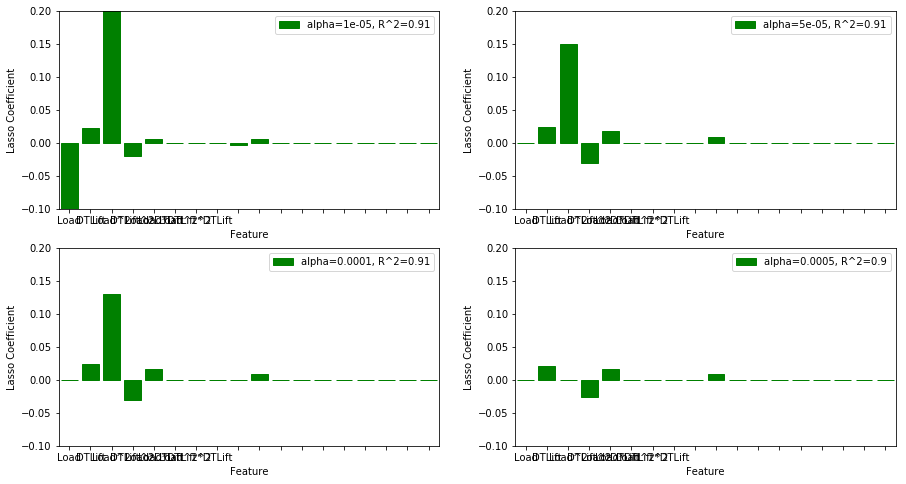

In [59]:
num_features = X_train.shape[1]

p = 0
num_plots = len(lasso_results)
fig, axes = plt.subplots(nrows=(num_plots+1)//2, ncols=2, figsize=(15, int(num_plots/2)*4))

for alpha,score,coef,RMSE in lasso_results:
    #print(alpha,score,coef)
    test = (alpha == 0.7)
    test = True
    plt.setp(axes, xticks=np.linspace(0,num_features+1, num=num_features+2), 
             xticklabels=['','Load','DTLift','Load^2','DTLift^2',
                          'Load*DTLift','Load*DTLift^2','Load^2*DTLift'],
             ylim=(-.1,.2),
             xlim=(0.5,num_features+.5))

    if test:
        axes[p//2,p%2].bar(range(1,num_features+1),coef,
                           label=f"alpha={alpha}, R^2={score:.2g}",
                           color='green',edgecolor='green')
        axes[p//2,p%2].set_xlabel("Feature")
        axes[p//2,p%2].set_ylabel("Lasso Coefficient")
        axes[p//2,p%2].legend()

        p +=1
        
if num_plots%2 == 1:
    axes[num_plots//2, 1].remove()  # don't display empty plot

plt.show()

In [61]:
X_train.columns

Index(['Load', 'DTLift', 'Load^2', 'Load*DTLift', 'Load^2*DTLift',
       'CompSH_mean', 'CompSH_std', 'CompSH_median', 'EvapApproach_mean',
       'EvapApproach_std', 'EvapApproach_median', 'CondApproach_mean',
       'CondApproach_std', 'CondApproach_median', 'REFLVL_mean', 'REFLVL_std',
       'REFLVL_median', 'RatedTon'],
      dtype='object')

## Samford

In [65]:
feat = ['AddOther','HigherOrder']
#feat = ['HigherOrder']

RatedTon = 1500

data_file = 'data/S1_chiller.csv'
X_train, y_train, df1 = get_Xy(data_file,RatedTon,feat)
print('CH1:',X_train.shape,y_train.shape)

data_file = 'data/S2_chiller.csv'
X2_test, y2_test, df2 = get_Xy(data_file,RatedTon,feat)
print('CH2:',X2_test.shape,y2_test.shape)

data_file = 'data/S3_chiller.csv'
X3_test, y3_test, df3 = get_Xy(data_file,RatedTon,feat)
print('CH3:',X3_test.shape,y3_test.shape)

data_file = 'data/S4_chiller.csv'
X4_test, y4_test, df4 = get_Xy(data_file,RatedTon,feat)
print('CH4:',X4_test.shape,y4_test.shape)

DataFrame rows with NaN removed:  3


/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load^2'] = df['Load']**2
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load*DTLift'] = df['Load']*df['DTLift']
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

CH1: (14272, 18) (14272,)
DataFrame rows with NaN removed:  16
CH2: (5459, 18) (5459,)
DataFrame rows with NaN removed:  7
CH3: (3835, 18) (3835,)
DataFrame rows with NaN removed:  8
CH4: (13705, 18) (13705,)


In [66]:
X_tot = pd.concat([X_train,X2_test,X3_test,X4_test])
y_tot = pd.concat([y_train,y2_test,y3_test,y4_test])

print(X_tot.shape)
X_tot.dropna().shape

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)

(37271, 18)
(22362, 18) (22362,)


In [67]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

0.25362060449484036
[-8.97450731e-01  8.49828523e-03  8.91471045e-01  1.31478874e-02
 -1.52863772e-02 -1.06935816e-03 -2.53127574e-04 -1.69054816e-03
  1.04292057e-03 -1.00678613e-03  3.35036797e-04  1.83485570e-04
 -6.69151593e-05  1.07022607e-04  4.35905151e-05  2.23692353e-03
  5.56606181e-05  0.00000000e+00]


In [68]:
print('train with S1:',lr.score(X_train,y_train))
print('test with S2: ',lr.score(X2_test,y2_test))
print('test with S3: ',lr.score(X3_test,y3_test))
print('test with S4: ',lr.score(X4_test,y4_test))

train with S1: 0.9812101907634712
test with S2:  0.9861083375228581
test with S3:  0.9647309141888166
test with S4:  0.9846449375011255


In [ ]:
pickle.dump(lift_lines,open('lift_lines.pkl','wb'))

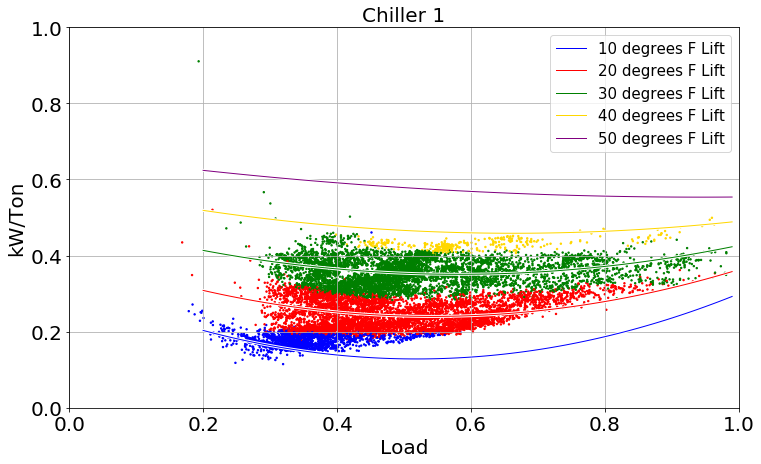

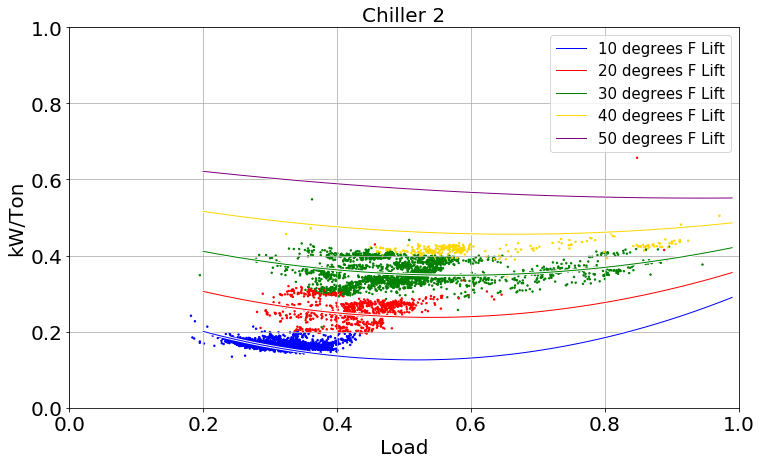

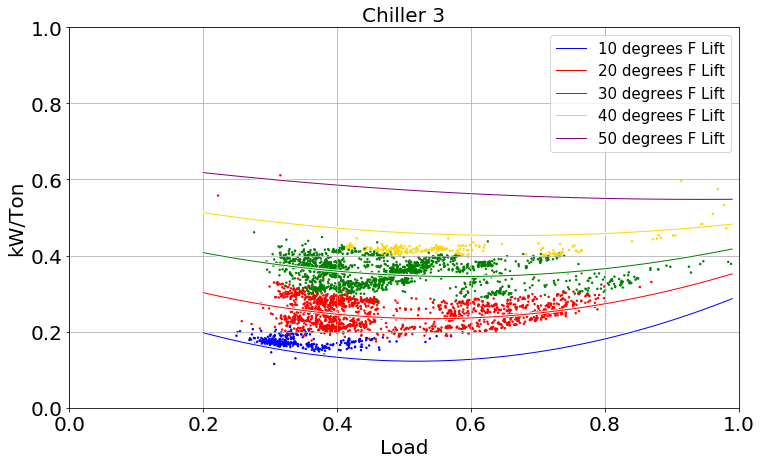

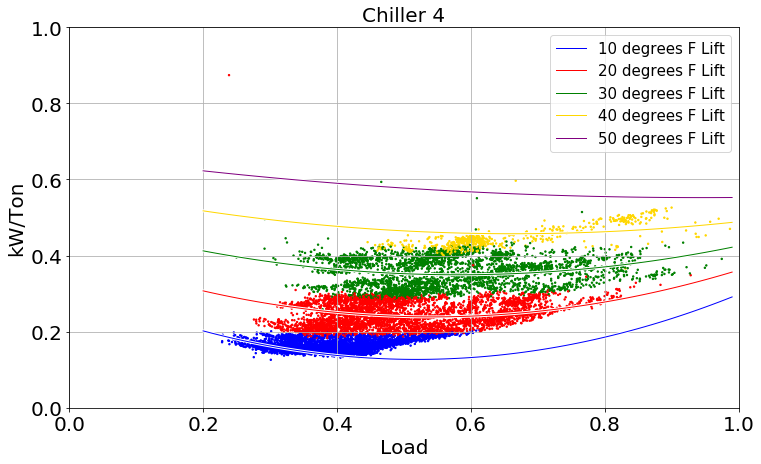

In [69]:
lift_lines = compute_lift_lines(lr, feat, df1, RatedTon, plot=False)
plot_curves(df1,lift_lines,'Chiller 1')

lift_lines = compute_lift_lines(lr, feat, df2, RatedTon, plot=False)
plot_curves(df2,lift_lines,'Chiller 2')

lift_lines = compute_lift_lines(lr, feat, df3, RatedTon, plot=False)
plot_curves(df3,lift_lines,'Chiller 3')

lift_lines = compute_lift_lines(lr, feat, df4, RatedTon, plot=False)
plot_curves(df4,lift_lines,'Chiller 4')

In [ ]:
pickle.dump(lift_lines,open('lift_lines.pkl','wb'))

## BCBS

CH1 YKKJKLH9-CWF 900 Tons   
CH2 YKKJKLH9-CWF 900 Tons   
CH3 YKKJKLH9-CWF 900 Tons   
CH4 YKKCKSH9-CWG 900 Tons   

In [62]:
feat = ['AddOther','HigherOrder']
#feat = ['HigherOrder']

RateTon = 900

data_file = 'data/B1_chiller.csv'
X_train, y_train, df1 = get_Xy(data_file,RatedTon,feat)
print('CH1:',X_train.shape,y_train.shape)

data_file = 'data/B2_chiller.csv'
X2_test, y2_test, df2 = get_Xy(data_file,RatedTon,feat)
print('CH2:',X2_test.shape,y2_test.shape)

data_file = 'data/B3_chiller.csv'
X3_test, y3_test, df3 = get_Xy(data_file,RatedTon,feat)
print('CH3:',X3_test.shape,y3_test.shape)

data_file = 'data/B4_chiller.csv'
X4_test, y4_test, df4 = get_Xy(data_file,RatedTon,feat)
print('CH4:',X4_test.shape,y4_test.shape)

DataFrame rows with NaN removed:  149


/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load^2'] = df['Load']**2
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load*DTLift'] = df['Load']*df['DTLift']
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

CH1: (33575, 18) (33575,)
DataFrame rows with NaN removed:  200
CH2: (36143, 18) (36143,)
DataFrame rows with NaN removed:  101
CH3: (29786, 18) (29786,)
DataFrame rows with NaN removed:  2
CH4: (23288, 18) (23288,)


In [63]:
X_tot = pd.concat([X_train,X2_test,X3_test,X4_test])
y_tot = pd.concat([y_train,y2_test,y3_test,y4_test])

print(X_tot.shape)
X_tot.dropna().shape

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)

(122792, 18)
(73675, 18) (73675,)


model coefficients: -65997130059.77594 [-6.89675357e-01  1.93263577e-02  8.10778377e-01 -9.63561174e-03
 -3.30995641e-03  4.43827333e+09 -1.32619917e+09  3.12989447e+09
  2.57727017e+09  2.21654712e+09  3.94530493e+09  1.54530054e+09
  3.34674724e+08  1.23228380e+09  1.42338628e+10  3.13459129e+09
 -1.58088379e+10  0.00000000e+00] 

train with B1: 0.9079661439025166
test with B2:  0.8824960222226547
test with B3:  0.9271641132374691
test with B4:  0.7823242456134122


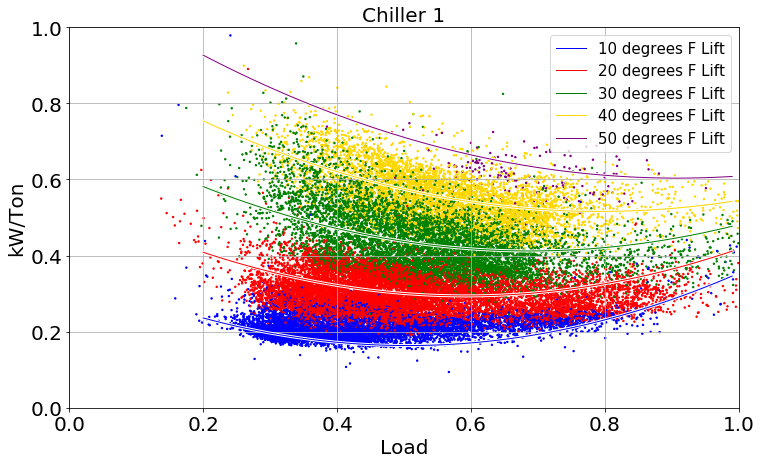

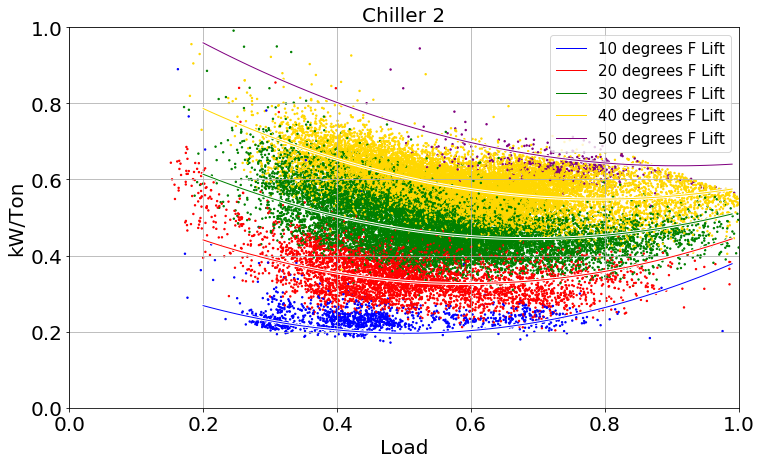

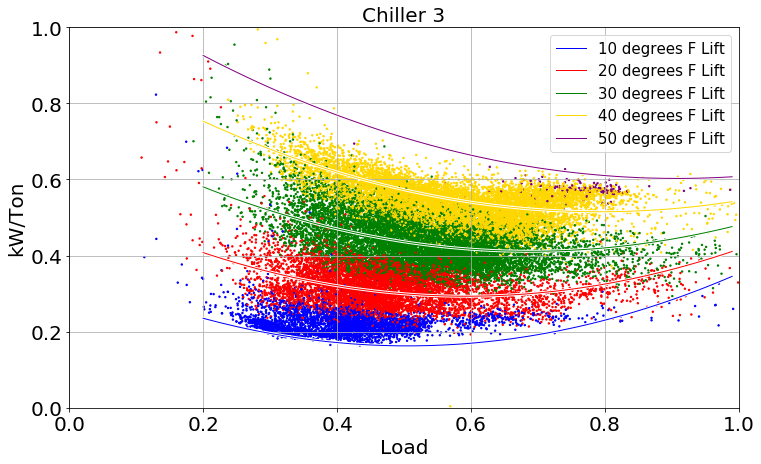

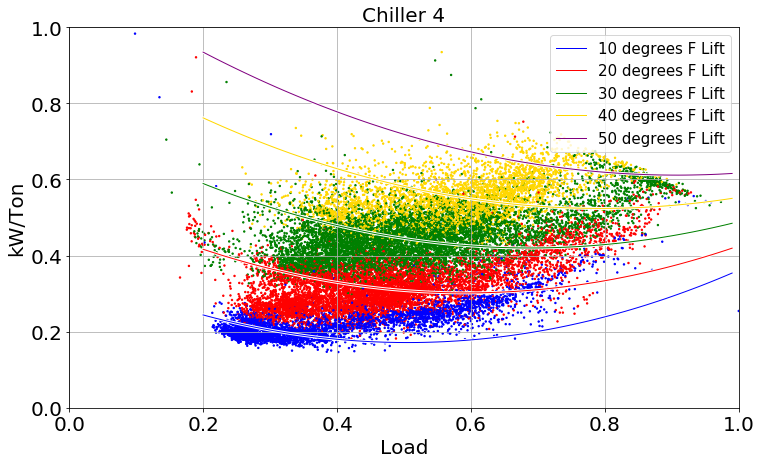

In [64]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print('model coefficients:',lr.intercept_, lr.coef_,'\n')

print('train with B1:',lr.score(X_train,y_train))
print('test with B2: ',lr.score(X2_test,y2_test))
print('test with B3: ',lr.score(X3_test,y3_test))
print('test with B4: ',lr.score(X4_test,y4_test))

lift_lines = compute_lift_lines(lr, feat, df1, RatedTon, plot=False)
plot_curves(df1,lift_lines,'Chiller 1')

lift_lines = compute_lift_lines(lr, feat, df2, RatedTon, plot=False)
plot_curves(df2,lift_lines,'Chiller 2')

lift_lines = compute_lift_lines(lr, feat, df3, RatedTon, plot=False)
plot_curves(df3,lift_lines,'Chiller 3')

lift_lines = compute_lift_lines(lr, feat, df4, RatedTon, plot=False)
plot_curves(df4,lift_lines,'Chiller 4')

## CMH

In [2]:
feat = ['AddOther','HigherOrder']
#feat = ['HigherOrder']

RatedTon = 1200

data_file = 'data/C1_chiller.csv'
X_train, y_train, df1 = get_Xy(data_file,RatedTon,feat)
print('CH1:',X_train.shape,y_train.shape)

data_file = 'data/C2_chiller.csv'
X2_test, y2_test, df2 = get_Xy(data_file,RatedTon,feat)
print('CH2:',X2_test.shape,y2_test.shape)

data_file = 'data/C3_chiller.csv'
X3_test, y3_test, df3 = get_Xy(data_file,RatedTon,feat)
print('CH3:',X3_test.shape,y3_test.shape)

data_file = 'data/C4_chiller.csv'
X4_test, y4_test, df4 = get_Xy(data_file,RatedTon,feat)
print('CH4:',X4_test.shape,y4_test.shape)

DataFrame rows with NaN removed:  1450


/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load^2'] = df['Load']**2
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:120: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  X['Load*DTLift'] = df['Load']*df['DTLift']
/Users/dana/metis/git/Metis_Bootcamp/Kojak_Project/util.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

CH1: (34965, 18) (34965,)
DataFrame rows with NaN removed:  9879
CH2: (25166, 18) (25166,)
DataFrame rows with NaN removed:  5067
CH3: (41276, 18) (41276,)
DataFrame rows with NaN removed:  2128
CH4: (43362, 18) (43362,)


In [3]:
X_tot = pd.concat([X_train,X2_test,X3_test,X4_test])
y_tot = pd.concat([y_train,y2_test,y3_test,y4_test])

print(X_tot.shape)
X_tot.dropna().shape

#divide in to train and test sets
X_train,X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.4,random_state=42)
print(X_train.shape, y_train.shape)

(144769, 18)
(86861, 18) (86861,)


0.8382294341707355
[-5.19267024e-01  1.27755472e-02  5.28992920e-01 -5.75570426e-03
 -5.41384682e-04  3.46180956e-04 -1.10416776e-02 -2.25215534e-02
 -1.87180110e-02  3.41472414e-03 -1.81216442e-02  1.16415192e-02
 -1.74847761e-02 -3.37152656e-03  3.22264273e-02 -5.81054491e-02
 -3.09991624e-02  0.00000000e+00]
train with C1: 0.9521602685502688
test with C2:  0.9067486110704069
test with C3:  0.9448655224091086
test with C4:  0.9552304891331744


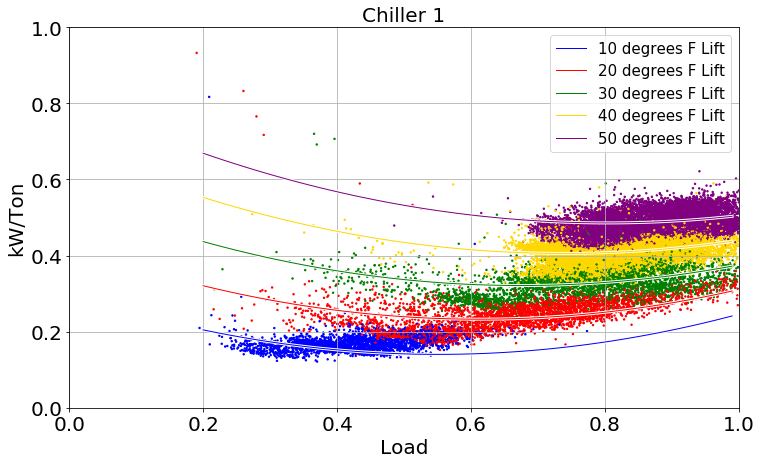

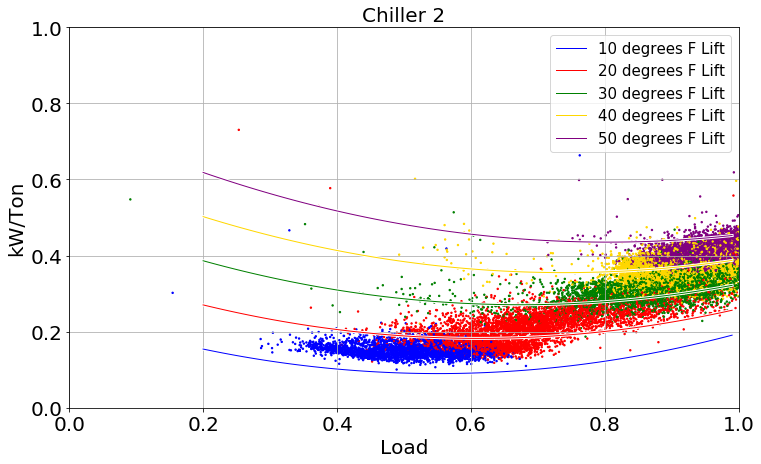

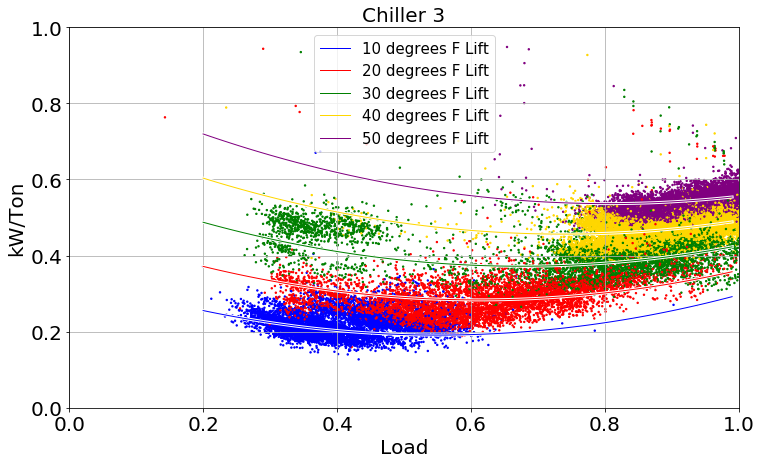

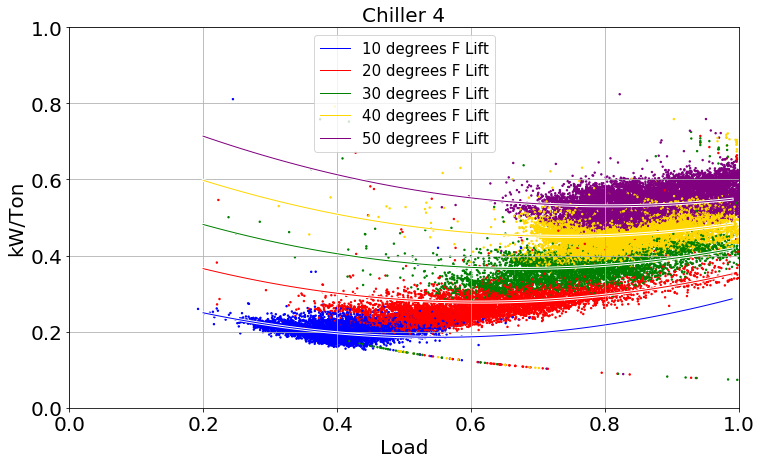

In [4]:
# Create an empty model
lr = LinearRegression()

# Fit the model to the full dataset
lr.fit(X_train, y_train)

# Print out the R^2 for the model against the full dataset
print(lr.intercept_)
print(lr.coef_)

print('train with C1:',lr.score(X_train,y_train))
print('test with C2: ',lr.score(X2_test,y2_test))
print('test with C3: ',lr.score(X3_test,y3_test))
print('test with C4: ',lr.score(X4_test,y4_test))

lift_lines = compute_lift_lines(lr, feat, df1, RatedTon, plot=False)
plot_curves(df1,lift_lines,'Chiller 1')

lift_lines = compute_lift_lines(lr, feat, df2, RatedTon, plot=False)
plot_curves(df2,lift_lines,'Chiller 2')

lift_lines = compute_lift_lines(lr, feat, df3, RatedTon, plot=False)
plot_curves(df3,lift_lines,'Chiller 3')

lift_lines = compute_lift_lines(lr, feat, df4, RatedTon, plot=False)
plot_curves(df4,lift_lines,'Chiller 4')

## Things to try

Random Forest Regression